# Загрузка

In [1]:
targets = ['Врем. сопротивление', 'Предел текучести']

In [2]:
ls_bath_col = [
    't˚ C воды в закалочной ванне', 
    't˚ C трубы после ванны',
    'время выдержки в закалочной ванне, сек.'
]

In [54]:
ls_need_col = [
       'Врем. сопротивление', 'Предел текучести',
       'Тип предела текучести (1186)',
       '1 зона по ВТР закалка',
       '1 зона ВТР и уставка отпуск', 
       '2 зона ВТР и уставка отпуск',
       '2 зона по ВТР закалка', '3 зона ВТР и уставка отпуск',
       '3 зона по ВТР закалка', 
       '4 зона ВТР и уставка отпуск',
       '5 зона ВТР и уставка отпуск',
       'Скорость прохождения трубы через спрейер, м/с',
       't˚ C трубы после спреера',
       'диаметр', 
#        'марка стали',
       'толщина стенки', 
       'шаг балок закалочная печь, сек',
       'шаг балок отпускная печь, сек',
       'C', 'Mn', 'Si', 'P', 'S',
       'Cr', 'Ni', 'Cu', 'Al', 'V', 'Ti', 'Nb', 'Mo', 'N',
       'ICD',
       'C-coef', 'Параметр закалка', 'Параметр отпуск',
       'Параметр отпуск новый', 'Параметр отпуск новый 2',
       'Параметр отпуск новый V',
       'Величина зерна']

In [4]:
import pandas as pd
import numpy as np
import import_ipynb
from my_libs.calc_features import *
import random

importing Jupyter notebook from C:\Users\kseniya.yuldasheva\Desktop\gitPNTZtoyuk_1\gitPNTZ\PNTZ\my_libs\calc_features.ipynb


In [5]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 1000

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, matthews_corrcoef, median_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict, cross_validate, train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from sklearn import model_selection
import time
from sklearn.neural_network import MLPRegressor
import os
os.environ["MKL_THREADING_LAYER"] = "GNU"
from sklearn.preprocessing import LabelEncoder
from time import time
from datetime import datetime
import json
from my_libs.save_lib import save_RF_model
from scipy.stats.stats import pearsonr

importing Jupyter notebook from C:\Users\kseniya.yuldasheva\Desktop\gitPNTZtoyuk_1\gitPNTZ\PNTZ\my_libs\save_lib.ipynb


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [10]:
df = pd.read_excel('DATA/prepared/prepared_hard.xlsx')
df_valid = pd.read_excel('DATA/prepared/prepared_hard_valid.xlsx')

In [29]:
df = pd.concat([df, df_valid])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


# Отделение таблицы с ванной и ее чистка

In [56]:
bath = df[~df['время выдержки в закалочной ванне, сек.'].isnull()].copy()

In [57]:
bath = bath[bath['время выдержки в закалочной ванне, сек.'] > 10]

In [58]:
bath = bath2spr(bath)

In [59]:
bath.reset_index(inplace=True, drop=True)

In [60]:
bath['Дата термообработки'] = bath['Дата термообработки'].apply(lambda x: str(x).replace(' 00:00:00', ''))
bath['Дата термообработки'] = bath['Дата термообработки'].apply(lambda x: str(x).replace('-', '.'))

In [61]:
tmp = []
for x in bath['Дата термообработки']:
    try:
        tmp.append(datetime.strptime(x, "%d.%m.%Y"))
    except ValueError:
        tmp.append(datetime.strptime(x, "%Y.%m.%d"))
bath['Дата термообработки'] = tmp

In [62]:
valid = bath[bath['Дата термообработки'].apply(lambda x:x.year)>2017].copy()
bath_ = bath[bath['Дата термообработки'].apply(lambda x:x.year)<2018].copy()

In [63]:
valid.shape, bath_.shape

((147, 211), (930, 211))

In [64]:
valid = valid[ls_need_col].dropna()
valid.reset_index(inplace=True, drop=True)

In [65]:
# Обрезана, оставлены только столбцы float
bath_ = bath_[ls_need_col].dropna().copy()
bath_.reset_index(inplace=True, drop=True)

In [66]:
bath_.shape, valid.shape

((870, 39), (146, 39))

In [67]:
bath_.columns

Index(['Врем. сопротивление', 'Предел текучести',
       'Тип предела текучести (1186)', '1 зона по ВТР закалка',
       '1 зона ВТР и уставка отпуск', '2 зона ВТР и уставка отпуск',
       '2 зона по ВТР закалка', '3 зона ВТР и уставка отпуск',
       '3 зона по ВТР закалка', '4 зона ВТР и уставка отпуск',
       '5 зона ВТР и уставка отпуск',
       'Скорость прохождения трубы через спрейер, м/с',
       't˚ C трубы после спреера', 'диаметр', 'толщина стенки',
       'шаг балок закалочная печь, сек', 'шаг балок отпускная печь, сек', 'C',
       'Mn', 'Si', 'P', 'S', 'Cr', 'Ni', 'Cu', 'Al', 'V', 'Ti', 'Nb', 'Mo',
       'N', 'ICD', 'C-coef', 'Параметр закалка', 'Параметр отпуск',
       'Параметр отпуск новый', 'Параметр отпуск новый 2',
       'Параметр отпуск новый V', 'Величина зерна'],
      dtype='object')

# Визуализация

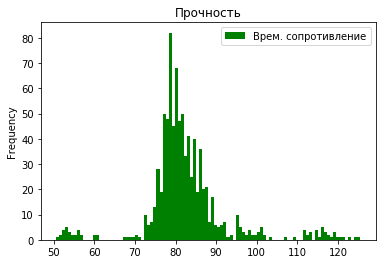

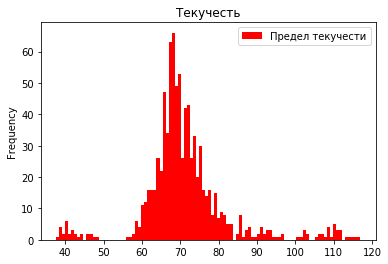

In [68]:
bath_.plot(y='Врем. сопротивление', kind='hist', color='green', title='Прочность', bins=100)
bath_.plot(y='Предел текучести', kind='hist', color='red', title='Текучесть', bins=100)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


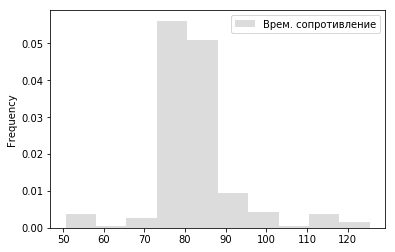

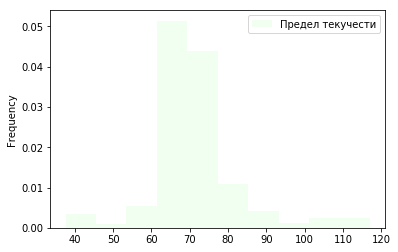

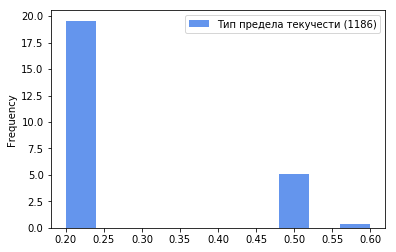

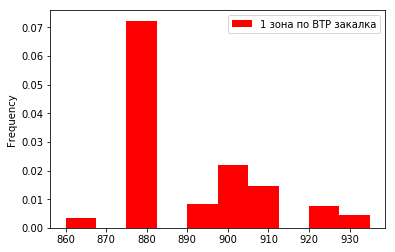

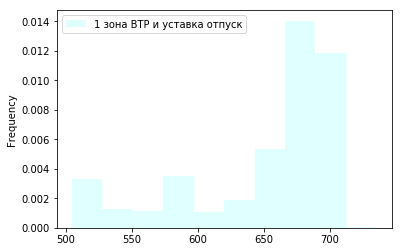

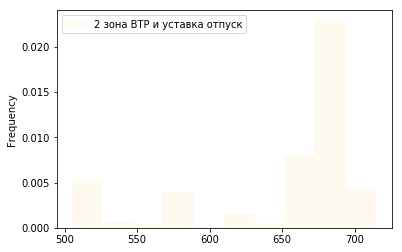

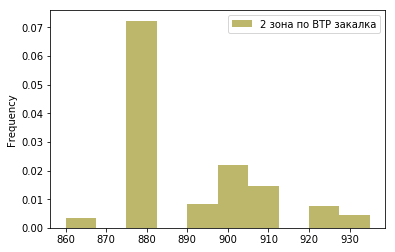

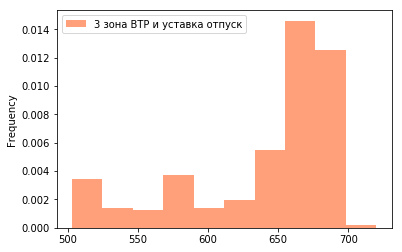

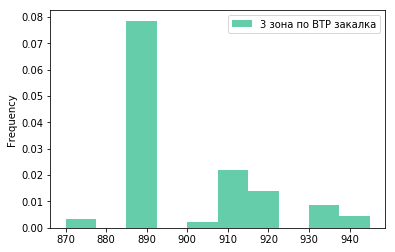

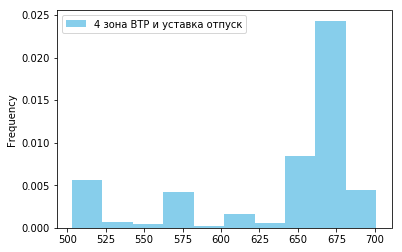

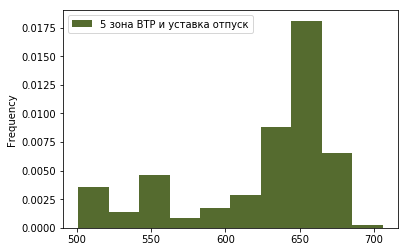

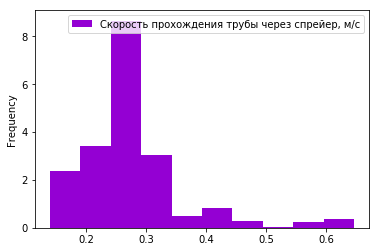

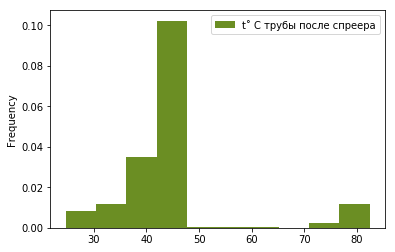

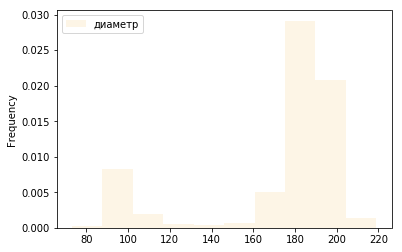

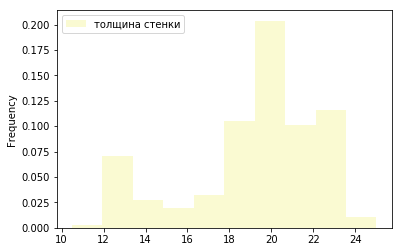

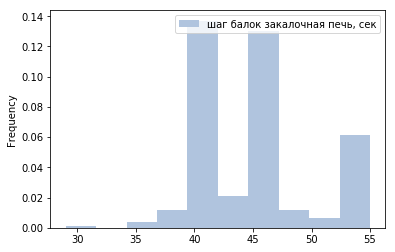

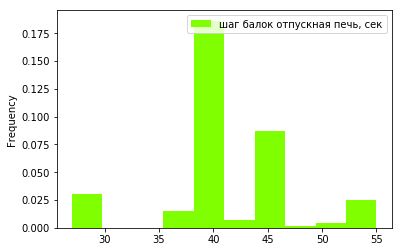

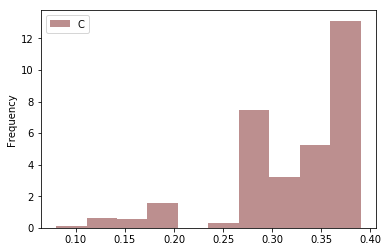

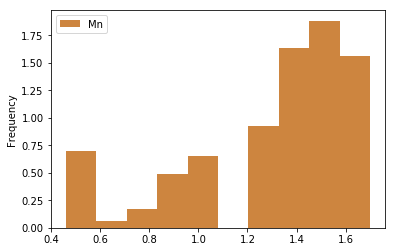

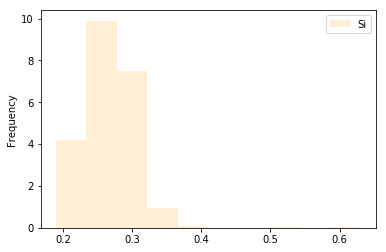

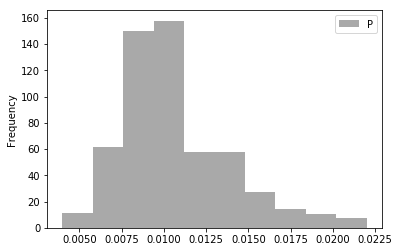

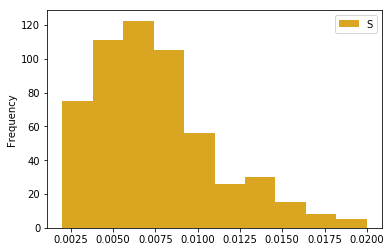

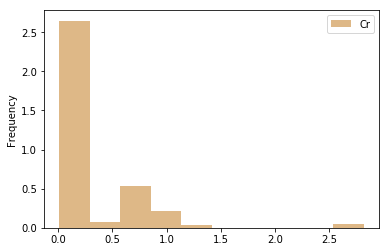

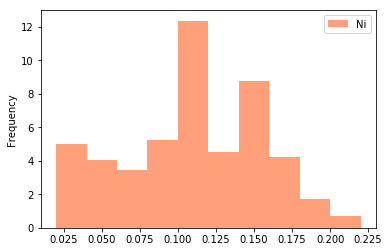

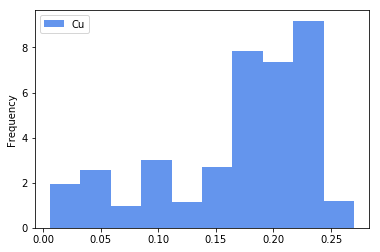

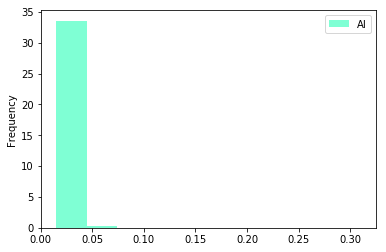

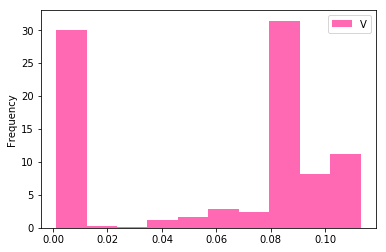

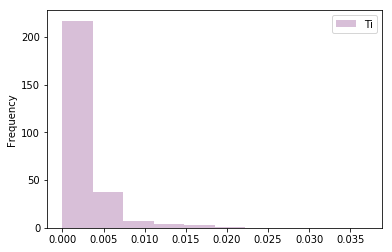

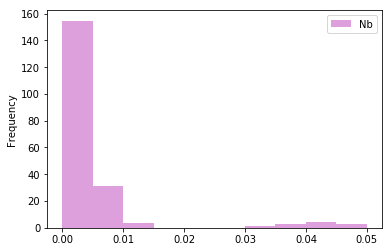

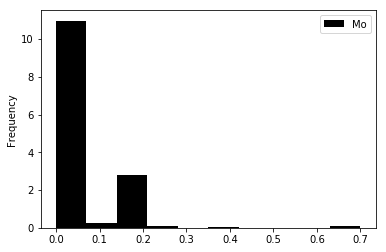

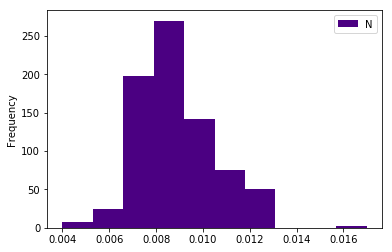

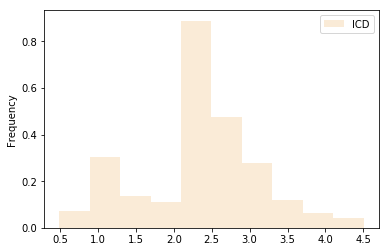

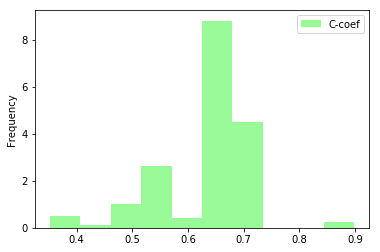

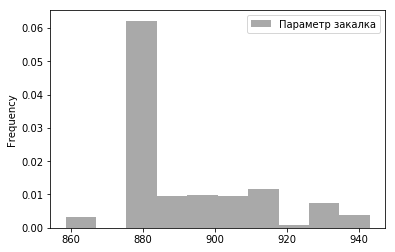

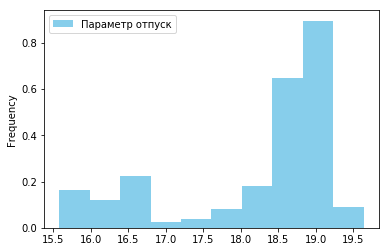

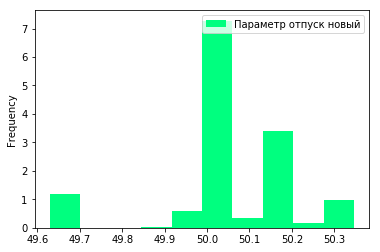

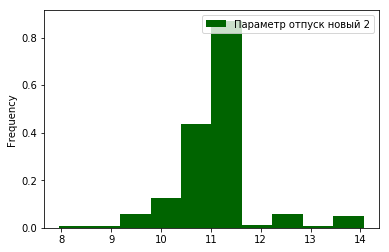

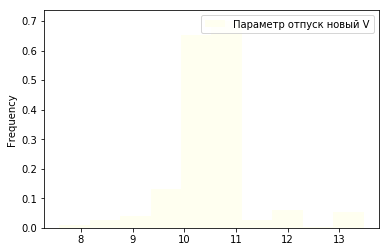

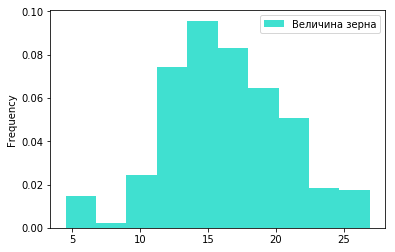

In [70]:
import matplotlib._color_data as mcd
import matplotlib.patches as mpatch

# Гля, рандомные цвета! *___*
overlap = {name for name in mcd.CSS4_COLORS}

plt.rcParams.update({'font.size': 10})
for col in ls_need_col:
    weight = None
    bath_.plot(y=col, kind='hist', 
              color=random.choice(list(overlap)),
             bins=10, density=True)

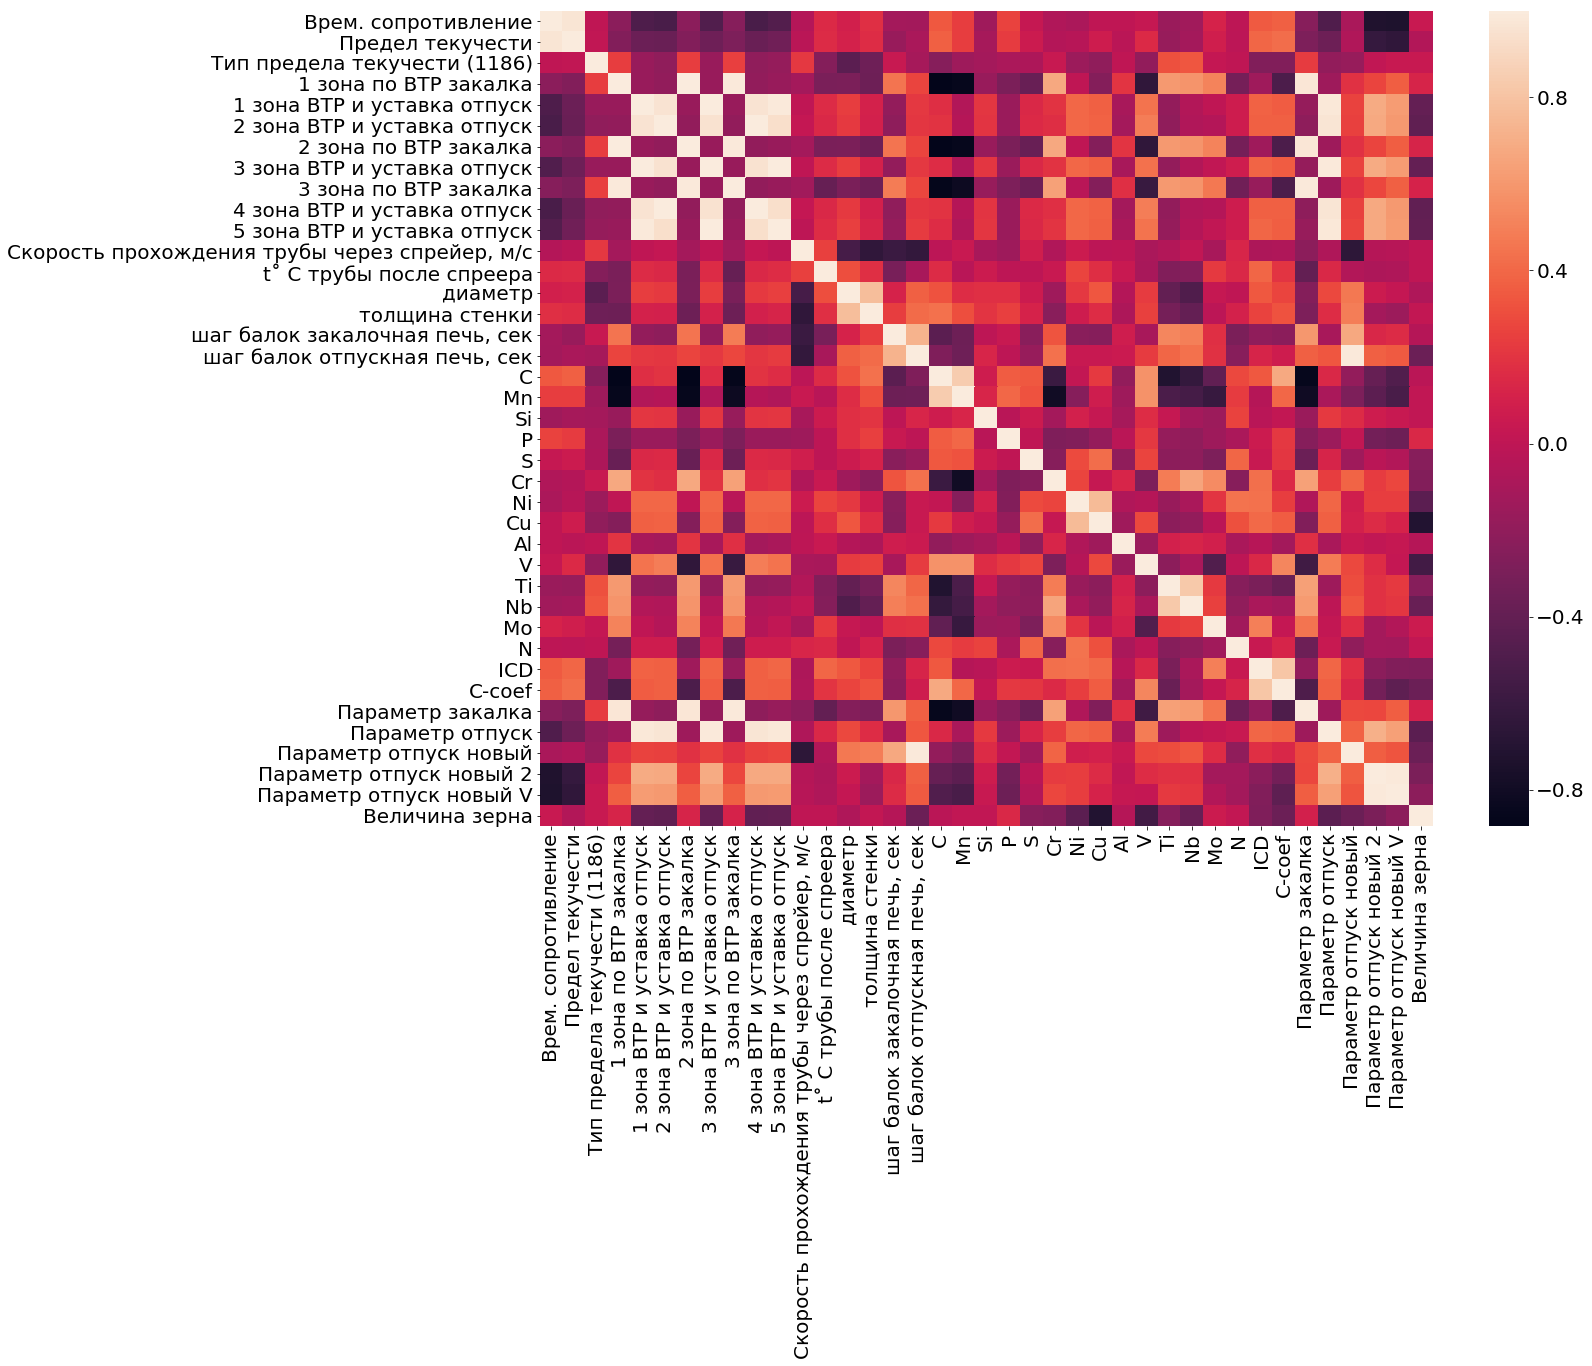

In [71]:
plt.rcParams.update({'font.size': 20})
plt.subplots(figsize=(20,15))

corr = bath_.corr()
corr_hm = sns.heatmap(corr)
fig = corr_hm.get_figure()
# fig.savefig('heatmap_bath.jpg', bbox_inches = 'tight')

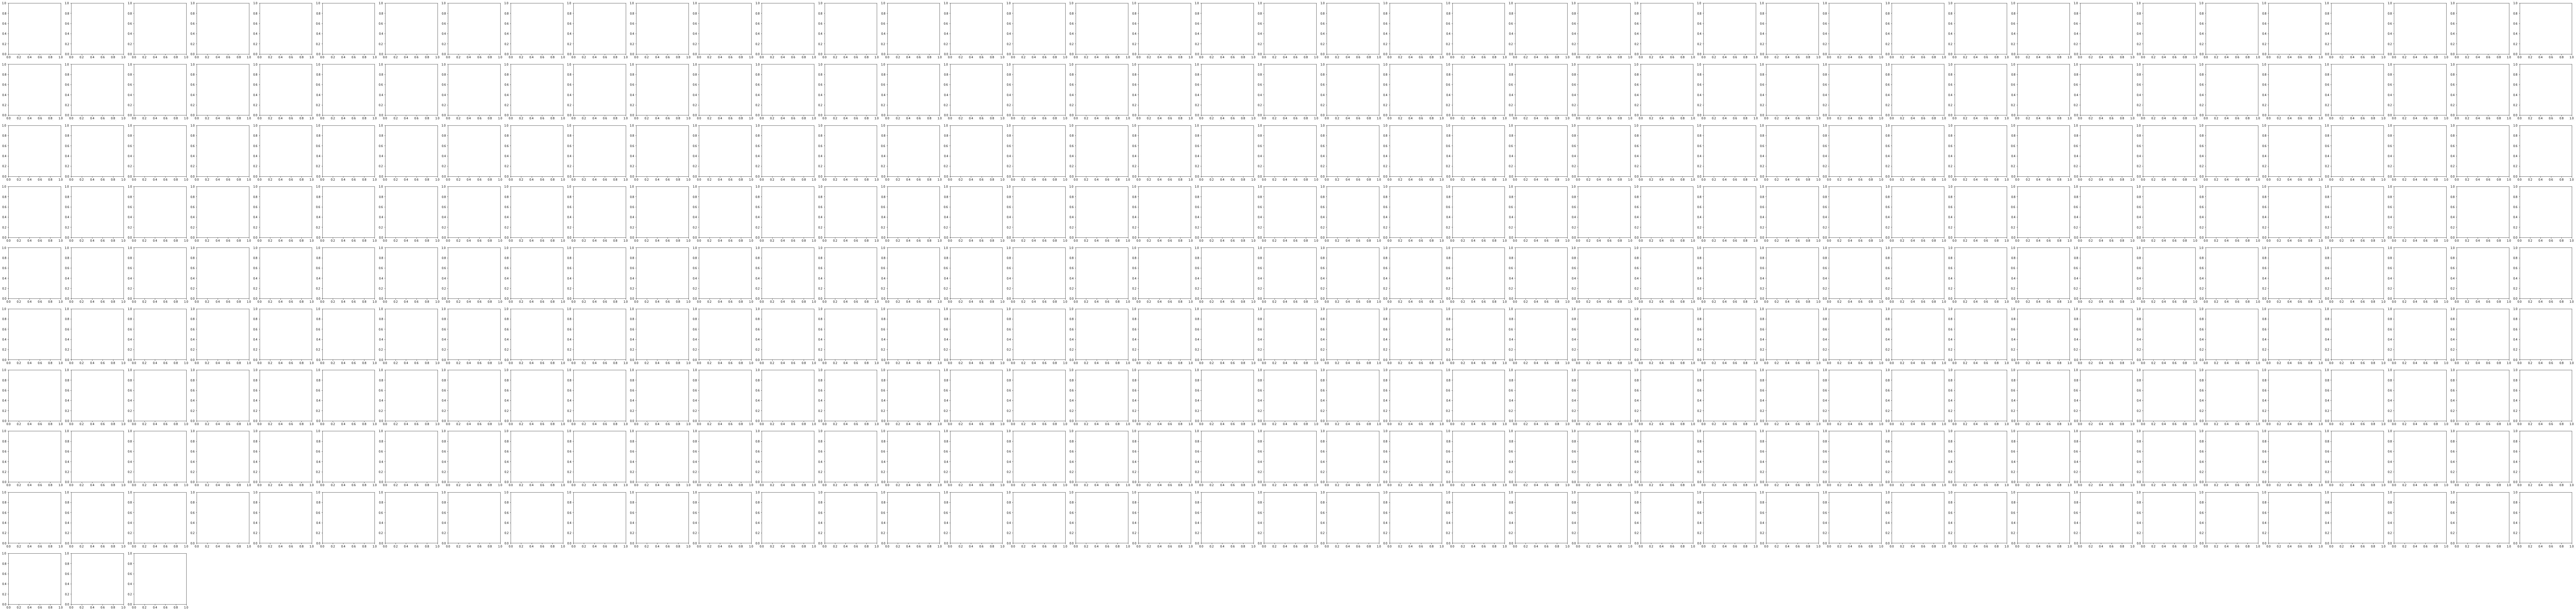

In [73]:
# plt.subplots(figsize=(20,20))
plt.figure(figsize=(20,20))
plt.rcParams.update({'font.size': 10})
pair = sns.pairplot(bath_[targets+ls_need_col], size=4)
# pair.savefig('pairplot_bath.jpg', bbox_inches = 'tight')

# Обучение

In [127]:
ls_train_col = ls_need_col.copy()
for s in targets:
    ls_train_col.remove(s) 

In [128]:
X = bath_[ls_train_col]
y = bath_[targets]
X_valid = valid[ls_train_col]
y_valid = valid[targets]

In [129]:
X.shape

(870, 37)

In [130]:
def print_and_return_score(x, y, est):
    y_pred = est.predict(x)
    scr = est.score(x, y)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    corr = []
    for i in range(y.columns.size):
        corr.append(np.corrcoef(y.iloc[:, i].T, 
                                y_pred[:, i]))
        
    print('Score: ', round(scr, 2))
    print('R^2: ', round(r2, 2))
    print('MAE: ', round(mae, 2))
    print('MSE: ', round(mse, 2))
    print('Correlation Врем. сопротивление: ', round(corr[0][0][1], 2))
    print('Correlation Предел текучести: ', round(corr[1][0][1], 2))
    return [scr, mae, mse, corr[0][0][1], corr[1][0][1]]

In [131]:
X_train, X_test,  y_train, y_test = train_test_split(X, y, test_size=0.3)

rfc = RandomForestRegressor(max_features = 9, max_depth = 15, min_samples_leaf = 2, n_estimators=100, criterion='mse')
rfc.fit(X_train, y_train)

scr, mae, mse, corr1, corr2 = print_and_return_score(X_test, y_test, rfc)

Score:  0.87
R^2:  0.87
MAE:  2.48
MSE:  14.43
Correlation Врем. сопротивление:  0.94
Correlation Предел текучести:  0.93


In [132]:
val = rfc.feature_importances_
lab = ls_train_col
dict_feat_import = dict(zip(lab, val))
ls_to_del = []
for feat, imp in zip(lab, val):
    print(feat, '  ', imp.round(2))
#     if imp.round(2) < 0.01:
#         ls_to_del.append(feat)

Тип предела текучести (1186)    0.01
1 зона по ВТР закалка    0.0
1 зона ВТР и уставка отпуск    0.03
2 зона ВТР и уставка отпуск    0.09
2 зона по ВТР закалка    0.0
3 зона ВТР и уставка отпуск    0.02
3 зона по ВТР закалка    0.0
4 зона ВТР и уставка отпуск    0.07
5 зона ВТР и уставка отпуск    0.01
Скорость прохождения трубы через спрейер, м/с    0.01
t˚ C трубы после спреера    0.01
диаметр    0.02
толщина стенки    0.01
шаг балок закалочная печь, сек    0.02
шаг балок отпускная печь, сек    0.0
C    0.05
Mn    0.01
Si    0.0
P    0.0
S    0.01
Cr    0.01
Ni    0.0
Cu    0.0
Al    0.0
V    0.0
Ti    0.01
Nb    0.02
Mo    0.01
N    0.0
ICD    0.08
C-coef    0.09
Параметр закалка    0.02
Параметр отпуск    0.05
Параметр отпуск новый    0.02
Параметр отпуск новый 2    0.14
Параметр отпуск новый V    0.17
Величина зерна    0.0


## GridSearchCV

In [133]:
param_grid = {
    'max_depth': range(2, 18, 2),
    'max_features': range(2, 18, 2),
    'min_samples_leaf': range(1, 5),
    'n_estimators': range(50, 300, 50)
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring='neg_mean_absolute_error')

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [135]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 1280 candidates, totalling 3840 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   55.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 3840 out of 3840 | elapsed:  2.9min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(2, 18, 2), 'max_features': range(2, 18, 2), 'min_samples_leaf': range(1, 5), 'n_estimators': range(50, 300, 50)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=2)

In [233]:
grid_search.best_params_

{'max_depth': 12,
 'max_features': 14,
 'min_samples_leaf': 1,
 'n_estimators': 150}

In [249]:
y_predict = grid_search.predict(X_test)

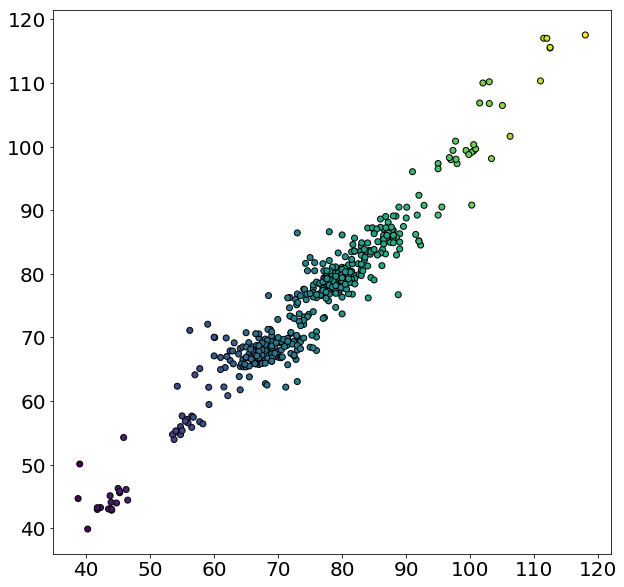

In [250]:
plt.subplots(figsize=(10,10))
plt.scatter(y_test, y_predict, marker='o', c=y_test, edgecolors='black', cmap='viridis')
# plt.colorbar()
plt.show()

## Cross-validation with KFold

In [251]:
kfold = model_selection.KFold(n_splits=5, shuffle=True)
scores = []
for train, test in kfold.split(X, y):
    x_train, y_train = X.iloc[train], y.iloc[train]
    x_test, y_test = X.iloc[test], y.iloc[test]
    grf = grid_search.best_estimator_
    grf.fit(x_train, y_train)

    scores.append(print_and_return_score(X_valid, y_valid, grf))

Score:  0.88
R^2:  0.88
MAE:  1.39
MSE:  3.56
Correlation Врем. сопротивление:  0.95
Correlation Предел текучести:  0.93
Score:  0.87
R^2:  0.87
MAE:  1.45
MSE:  3.73
Correlation Врем. сопротивление:  0.94
Correlation Предел текучести:  0.93
Score:  0.88
R^2:  0.88
MAE:  1.31
MSE:  3.59
Correlation Врем. сопротивление:  0.95
Correlation Предел текучести:  0.93
Score:  0.87
R^2:  0.87
MAE:  1.48
MSE:  3.89
Correlation Врем. сопротивление:  0.94
Correlation Предел текучести:  0.92
Score:  0.88
R^2:  0.88
MAE:  1.4
MSE:  3.46
Correlation Врем. сопротивление:  0.95
Correlation Предел текучести:  0.93


In [252]:
for i in range(5):
    tmp = []
    for j in range(5):
        tmp.append(scores[j][i])
    print(round(np.mean(tmp), 2))

0.88
1.41
3.65
0.95
0.93


In [253]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
grf = grid_search.best_estimator_
grf.fit(X_train, y_train)
scr, mae, mse, corr1, corr2 = print_and_return_score(X_test, y_test, grf)

Score:  0.92
R^2:  0.93
MAE:  2.56
MSE:  11.85
Correlation Врем. сопротивление:  0.97
Correlation Предел текучести:  0.96


In [254]:
y_pred = pd.DataFrame(grf.predict(X_valid), columns=['прогноз Врем. сопротивление', 'прогноз Предел текучести'])
y_pred.reset_index(inplace=True, drop=True)
y_valid.reset_index(inplace=True, drop=True)

scr, mae, mse, corr1, corr2 = print_and_return_score(X_valid, y_valid, grf)

score_df = pd.concat([pd.DataFrame({'Score':[scr], 'MAE':[mae], 'MSE':[mse], 'Correlation Врем. сопротивление':[corr1],
                                                     'Correlation Предел текучести':[corr2]}),
                      y_pred,
                      y_valid],
                    axis=1)

score_df['MAE Предел текучести'] = np.abs(score_df['Предел текучести'] - score_df['прогноз Предел текучести'])
score_df['MAE Врем. сопротивление'] = np.abs(score_df['Врем. сопротивление'] - score_df['прогноз Врем. сопротивление'])

Score:  0.87
R^2:  0.87
MAE:  1.41
MSE:  3.75
Correlation Врем. сопротивление:  0.95
Correlation Предел текучести:  0.93


In [260]:
save_RF_model(grf, list(ls_train_col), 'H+YS Bath GS', score_df)

Модель сохранена


In [82]:
val = rfc.feature_importances_
lab = ls_train_col
dict_feat_import = dict(zip(lab, val))

<BarContainer object of 37 artists>

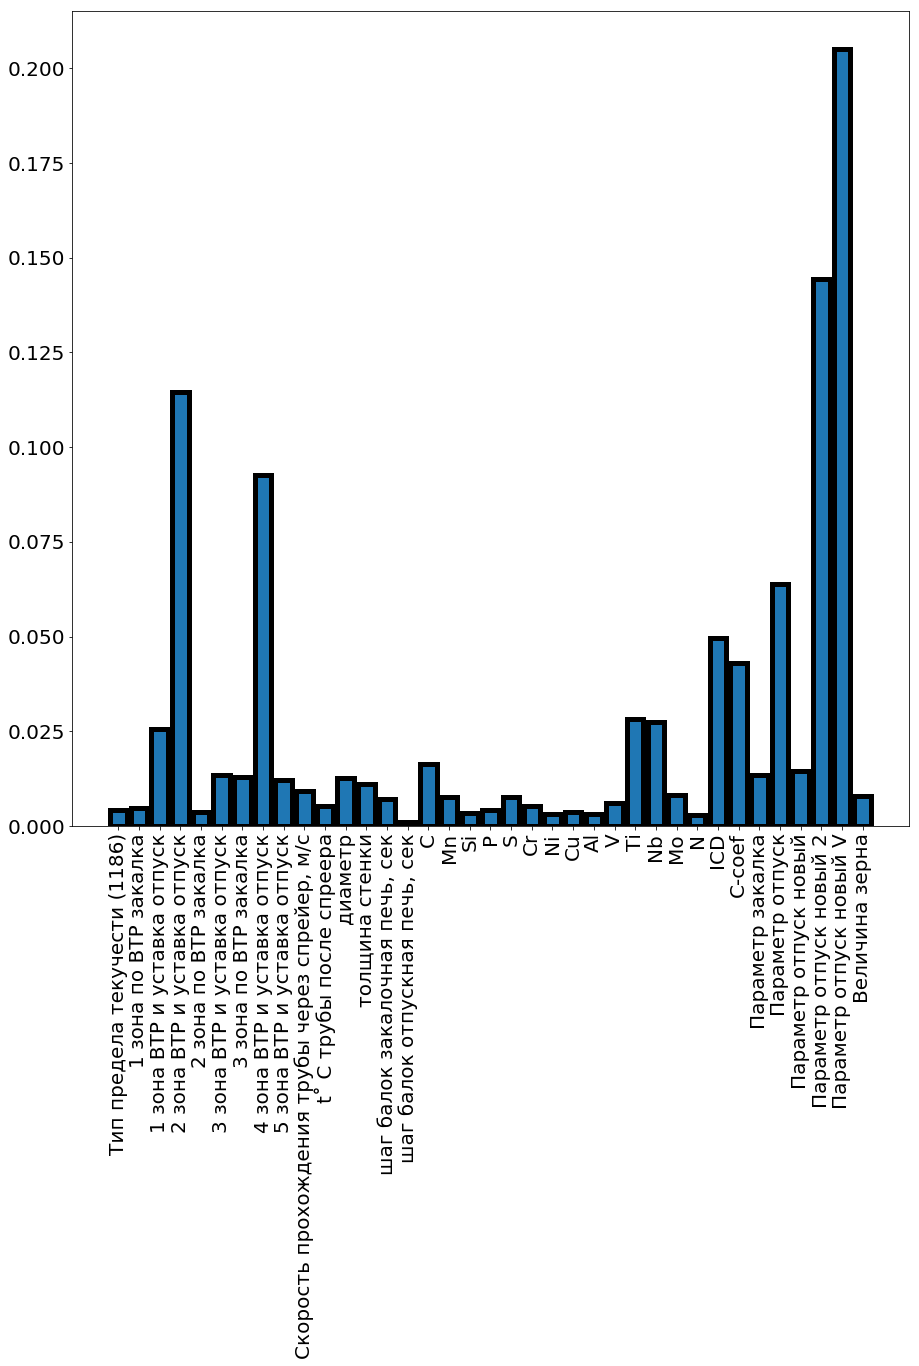

In [83]:
# plt.subplots(figsize=(20,20))
plt.figure(figsize=(15,15))
plt.rcParams.update({'font.size': 20})
plt.xticks(rotation=90)
plt.bar(dict_feat_import.keys(), dict_feat_import.values(), edgecolor='black', linewidth=5)